In [3]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re
import numpy as np
from shutil import copyfile, rmtree
from datetime import datetime
from fuzzywuzzy import process

# IMAGE IMPORTS
from PIL import Image

# GIS IMPORTS
from affine import Affine
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point, MultiPoint

# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

In [4]:
input_dir = r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-13_19-10-57\Inputs\\"
proc_dir  = r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-13_19-10-57\Outputs\\"

# LIST ALL IMAGES IN DIRECTORY
image_files = glob.glob(f"{input_dir}/*")

# FILTER IMAGES USING HEURISTICS TO GET TILEINDICES
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(input_dir + "\\*" + pattern + "*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# GET ACTUAL TILES
tiles       = list(set(image_files) - set(index_files))
tiles_bns   = [os.path.basename(tile).split(".")[0] for tile in tiles]

with open(f'{proc_dir}IndexCoords.pkl', 'rb') as handle:
    dict = pickle.load(handle)

In [3]:
import re
tile_names = list(dict.keys())
def findIndexKey(mystring):
    # INDEX KEY IS DEFINED AS ANY NUMBERS BEFORE AN "_" AND "IND" 
    return re.sub(r"[^0-9]", "", os.path.basename(mystring).split(".")[0].split("_")[0].split("IND")[0])

processed_indices = list(dict.keys())

tile_keys = [findIndexKey(a) for a in tile_names]
inde_keys = [findIndexKey(a) for a in processed_indices]

def getIndivDict(a, index):
    # PROCESSES TILE OUTPUTS TO ONLY INCLUDE TILE BBOXES AND NAMES
    out = []
    for k, v in a[index].items():
        if k in ["county", "transform_info", "output_transform",]:
            continue
        out.append({'tile' : k, 'index' : index, 'coords' : v['coords'], })
    return out

db = {}

# FOR EACH INDEX KEY
for key in np.unique(inde_keys):
    # GET ALL INDICES THAT HAVE THAT KEY
    match_indices = [processed_indices[i] for i, a in enumerate(inde_keys) if a == key]

    # EXTRACT ALL THE TILE INFORMATION FROM THE MATCHING INDICES
    found_tiles   = [getIndivDict(dict, index) for index in match_indices]
    all_tiles = sum(found_tiles, [])

    # PUT IN OUTPUT STRUCTURE
    temp = pd.DataFrame(all_tiles)
    temp = temp.fillna("")
    db[key] = temp
    
    

In [49]:
def findTileDatabase(p):
    test = db.get(findIndexKey(p), None)
    if test is None:
        for i in [6, 5]:
            if test is not None:
                continue
            test = db.get(findIndexKey(p)[:i], None)
    return test

bad = 0
tile_coords = []
for i, p in tqdm(enumerate(tiles_bns), total=len(tiles_bns)):
    # FIND TILES 
    curr_db = findTileDatabase(p)
    if curr_db is None or curr_db.empty:
        bad = bad+1
        print("COULD NOT FIND TILE")
        print(p)
        continue

    # KEEP NUMERIC PART OF TILE NAME
    p = re.sub(r"[^0-9]", "", p) 

    # GET EQUAL-LENGTH TILENAMES FOR MATCHING
    tns = [a[:len(p)] for a in curr_db['tile'].tolist()]

    # PERFORM MATCHING
    match, score = process.extractOne(p, tns)
    if score > 90:
        tile_coords.append(curr_db[curr_db['tile'] == match]["coords"].tolist())
    else:
        bad = bad+1
        print(f"COULD NOT FIND MATCHES")
        print(p, match, process.extract(p, tns))
        tile_coords.append([])
'''
# for i, p in tqdm(enumerate(tile_names), total=len(tile_names)):
    print(i, p, findIndexKey(p))
    test = db.get(findIndexKey(p), None)
    if test is None:
        for i in [5, 6]:
            if test is not None:
                continue
            test = db.get(findIndexKey(p)[:i], None)
            # test = db[findIndexKey(p)[:i]]
    error

'''

  0%|          | 0/1406 [00:00<?, ?it/s]

COULD NOT FIND MATCHES
48028721 48028701 [('48028701', 88), ('48028702', 88), ('48028701', 88), ('48028701', 88), ('48028702', 88)]
COULD NOT FIND MATCHES
48547053 48547003 [('48547003', 88), ('48547003', 88), ('48547003', 88), ('48547003', 88), ('48547003', 88)]
COULD NOT FIND MATCHES
4854863 4854860 [('4854860', 86), ('', 0), ('', 0)]
COULD NOT FIND MATCHES
4804243  [('', 0), ('', 0), ('', 0)]
COULD NOT FIND MATCHES
4854885 485488G [('485488G', 86), ('4854880', 86), ('4854880', 86), ('4854880', 86), ('4854880', 86)]
COULD NOT FIND MATCHES
480296107 480296007 [('480296007', 89), ('480296007', 89), ('480296010', 89), ('480296007', 89), ('480296017', 89)]
COULD NOT FIND MATCHES
482010265 482010 [('482010', 90), ('482010026', 89), ('482010027', 78), ('482010028', 78), ('482013023', 78)]
COULD NOT FIND MATCHES
48547038 48547003 [('48547003', 88), ('48547003', 88), ('48547003', 88), ('48547003', 88), ('48547003', 88)]
COULD NOT FIND MATCHES
48029683 l480296 [('l480296', 80), ('1480296', 80

'\n# for i, p in tqdm(enumerate(tile_names), total=len(tile_names)):\n    print(i, p, findIndexKey(p))\n    test = db.get(findIndexKey(p), None)\n    if test is None:\n        for i in [5, 6]:\n            if test is not None:\n                continue\n            test = db.get(findIndexKey(p)[:i], None)\n            # test = db[findIndexKey(p)[:i]]\n    error\n\n'

In [52]:
tiles

['C:\\Users\\fhacesga\\Desktop\\FIRMsDigitizing\\processing\\2024-05-13_19-10-57\\Inputs\\4802960160B.jpg',
 'C:\\Users\\fhacesga\\Desktop\\FIRMsDigitizing\\processing\\2024-05-13_19-10-57\\Inputs\\480287B_21.tif',
 'C:\\Users\\fhacesga\\Desktop\\FIRMsDigitizing\\processing\\2024-05-13_19-10-57\\Inputs\\485470B_53.tif',
 'C:\\Users\\fhacesga\\Desktop\\FIRMsDigitizing\\processing\\2024-05-13_19-10-57\\Inputs\\485486A_3.tif',
 'C:\\Users\\fhacesga\\Desktop\\FIRMsDigitizing\\processing\\2024-05-13_19-10-57\\Inputs\\480424B_3.tif',
 'C:\\Users\\fhacesga\\Desktop\\FIRMsDigitizing\\processing\\2024-05-13_19-10-57\\Inputs\\485488A_5.tif',
 'C:\\Users\\fhacesga\\Desktop\\FIRMsDigitizing\\processing\\2024-05-13_19-10-57\\Inputs\\480296A_107.tif',
 'C:\\Users\\fhacesga\\Desktop\\FIRMsDigitizing\\processing\\2024-05-13_19-10-57\\Inputs\\48201C0265G.jpg',
 'C:\\Users\\fhacesga\\Desktop\\FIRMsDigitizing\\processing\\2024-05-13_19-10-57\\Inputs\\485470B_38.tif',
 'C:\\Users\\fhacesga\\Desktop\\FIRMs

In [41]:
db.keys()

dict_keys(['480035', '480036', '480037', '480038', '480039', '480040', '480041', '480042', '480043', '480045', '480046', '480047', '480048', '480049', '480077', '480233', '480267', '480269', '480287', '480289', '48029', '480290', '480291', '480293', '480295', '480296', '480297', '480298', '480299', '480300', '480301', '480304', '480305', '480307', '480308', '480311', '480313', '480315', '480423', '480424', '480641', '480692', '480710', '481094', '481141', '481569', '48201', '485456', '485466', '485468', '485469', '485470', '485486', '485487', '485488', '485491', '485513', '485514', '485516'])

In [241]:
matches = process.extract(p, test['tile'].tolist())
print(matches)

[('4854700120D', 100), ('4854700120', 95), ('4854700120', 95), ('48547001260', 91), ('4854700127D', 91)]


In [230]:
p

'480035IND0_0490.jpg'

In [21]:
def filterItems(index_list, elements):
    for e in elements:
        if e in index_list:
            index_list.remove(e)
    return index_list

gen_tile_list = []
gen_bbox_list = []

for k, v in dict.items():
    index_list = list(v.keys())
    index_list = filterItems(index_list, [None, 'county', 'transform_info'])

    coord_list = [v[a]['coords'] for a in index_list]

    gen_tile_list.extend(index_list)
    gen_bbox_list.extend(coord_list)

In [36]:
gen_tile_list = [re.sub("[^0-9]", "", x) for x in gen_tile_list]
tile_names    = [re.sub("[^0-9]", "", x) for x in tile_names]  

In [114]:
stuff = {}

for i, p in tqdm(enumerate(tile_names), total=len(tile_names)):
    name_list = [a[:len(p)] for a in gen_tile_list]
    matches = process.extract(p, name_list)
    # print(p, matches)
    out = []
    for t in matches:
        bboxes = []
        if t[1] > 90:
            bboxes.extend([gen_bbox_list[i] for i in range(len(name_list)) if name_list[i] == t[0]])
        stuff[p] = bboxes

  0%|          | 0/1406 [00:00<?, ?it/s]

In [5]:
def findRoads(image, model=None, num_classes=2, num_pyramids=2,
                cnn_run_params=None, cnn_creation_params=None, device="cuda",
                model_checkpoint=f"{data_dir}/FANN/checkpoint_101023.pth"):
    
    if cnn_run_params is None:
        cnn_run_params = {
            "tilesize"   : 2048,
            "edges"      : 0,
            "dims_rep"   : None,
            "n_pyramids" : num_pyramids,
            "num_dim"    : num_classes,
            "device"     : device
        }
    
    if cnn_creation_params is None:
        cnn_creation_params = {
            "num_classes" : num_classes,
            "inputsize"   : num_pyramids,
        }
    
    # Input handling
    if isinstance(image, np.ndarray):
        image = [image] # Make iterable if needed
    
    # Initialize model if needed
    if model is None:
        model = TPNN(**cnn_creation_params)
        model.load_state_dict(torch.load(model_checkpoint)['model_state_dict'])
    model = model.to(device)
    
    # PROCESS IMAGE
    for im in image:
        outputs, _ = split_and_run_cnn(im, model, **cnn_run_params)
    
    # background, grid, roads = outputs[:, :, 0], outputs[:, :, 1], outputs[:, :, 2]
    
    model = model.to("cpu")
    torch.cuda.empty_cache()
    
    outputs = outputs * 255
    outputs = outputs.astype(np.uint8)
    
    # return (background.T, grid.T, roads.T), model
    return outputs, model


def getRoadPoints(fn, model=None):
    # LOAD IMAGE AS NUMPY ARRAY
    image = np.asarray(cv2.imread(fn))

    # RUN CNN
    out, model = findRoads(image, model=model)

    # THIN CNN OUTPUTS
    thin = cv2.ximgproc.thinning(out[:, :, 1], thinningType=cv2.ximgproc.THINNING_GUOHALL)

    # OUTPUT X AND Y
    y, x = np.where(np.asarray(thin > 0))
    
    return y, x, model, thin, out

  0%|          | 0/2 [00:00<?, ?it/s]

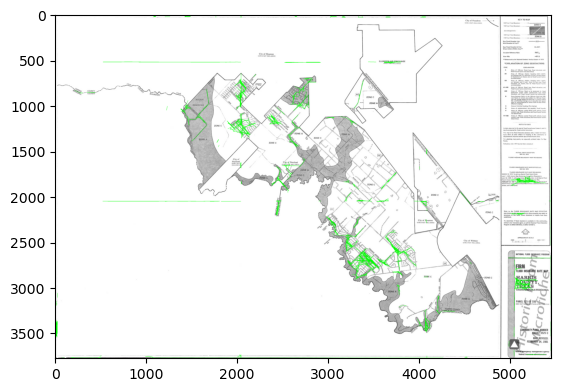

In [16]:
def findIntersections(lines):
    intersections = []
    for i in tqdm(range(len(lines))):
        for j in range(i+1, len(lines)):
            line1 = lines[i][0]
            line2 = lines[j][0]

            x1, y1, x2, y2 = line1
            x3, y3, x4, y4 = line2

            # Calculate intersection point
            denominator = ((x1 - x2) * (y3 - y4)) - ((y1 - y2) * (x3 - x4))
            if denominator != 0:
                intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
                intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

                # Add intersection point to list
                intersections.append((int(intersect_x), int(intersect_y)))
    return intersections

def findInetersections_vectorized(lines):
    intersections = []

    # Convert lines to numpy array for easier manipulation
    lines = lines[:, 0, :]  # Extracting the lines from the unnecessary dimensions

    # Extracting line coordinates
    x1, y1, x2, y2 = lines[:, 0], lines[:, 1], lines[:, 2], lines[:, 3]

    # Reshaping to make calculations easier
    x1, y1, x2, y2 = x1.reshape(-1, 1), y1.reshape(-1, 1), x2.reshape(-1, 1), y2.reshape(-1, 1)

    # Calculate differences and determinants
    dx, dy = x2 - x1, y2 - y1
    det = dx * dy[:, np.newaxis] - dy * dx[:, np.newaxis]

    # Check for non-parallel lines
    non_parallel_mask = det != 0

    # Calculate intersection points
    intersect_x = ((x1 * y2 - y1 * x2) * dx - (x1 - x2) * (x1 * dy - y1 * dx)) / det
    intersect_y = ((x1 * y2 - y1 * x2) * dy - (y1 - y2) * (x1 * dy - y1 * dx)) / det

    # Check for valid intersections
    valid_mask = (intersect_x >= 0) & (intersect_y >= 0) & (intersect_x < image.shape[1]) & (intersect_y < image.shape[0])

    # Filter out invalid intersections and non-parallel lines
    valid_intersections = np.column_stack((intersect_x[valid_mask & non_parallel_mask], intersect_y[valid_mask & non_parallel_mask]))

    # Convert intersection points to integer coordinates
    valid_intersections = valid_intersections.astype(int)

    # Remove duplicate intersections
    valid_intersections = np.unique(valid_intersections, axis=0)

    return valid_intersections

def findInetersections_shapely(lines): 
    line_strings = [LineString([(line[0][0], line[0][1]), (line[0][2], line[0][3])]) for line in lines]

    # Create a GeoDataFrame with LineString objects
    gdf = gpd.GeoDataFrame(geometry=line_strings)

    # Calculate intersections
    temp = gdf.unary_union.intersection(gdf.geometry)
    intersection_points = gpd.GeoSeries([point for point in temp if isinstance(point, MultiPoint) or isinstance(point, Point)])
    intersections = gpd.GeoDataFrame(geometry=intersection_points.explode(index_parts=False)).reset_index(drop=True)
    return intersections

fn = tiles[4]
points = getRoadPoints(fn, )
y, x, model, thin = points

image = np.asarray(cv2.imread(fn))

# Perform Hough Line Transform
lines  = cv2.HoughLinesP(thin, 1, np.pi/720, threshold=20, minLineLength=20, maxLineGap=50)
inters = findInetersections_shapely(lines)

# Plot the lines
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Convert BGR image to RGB for plotting
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)


In [18]:
plt.imsave("test.png", thin)

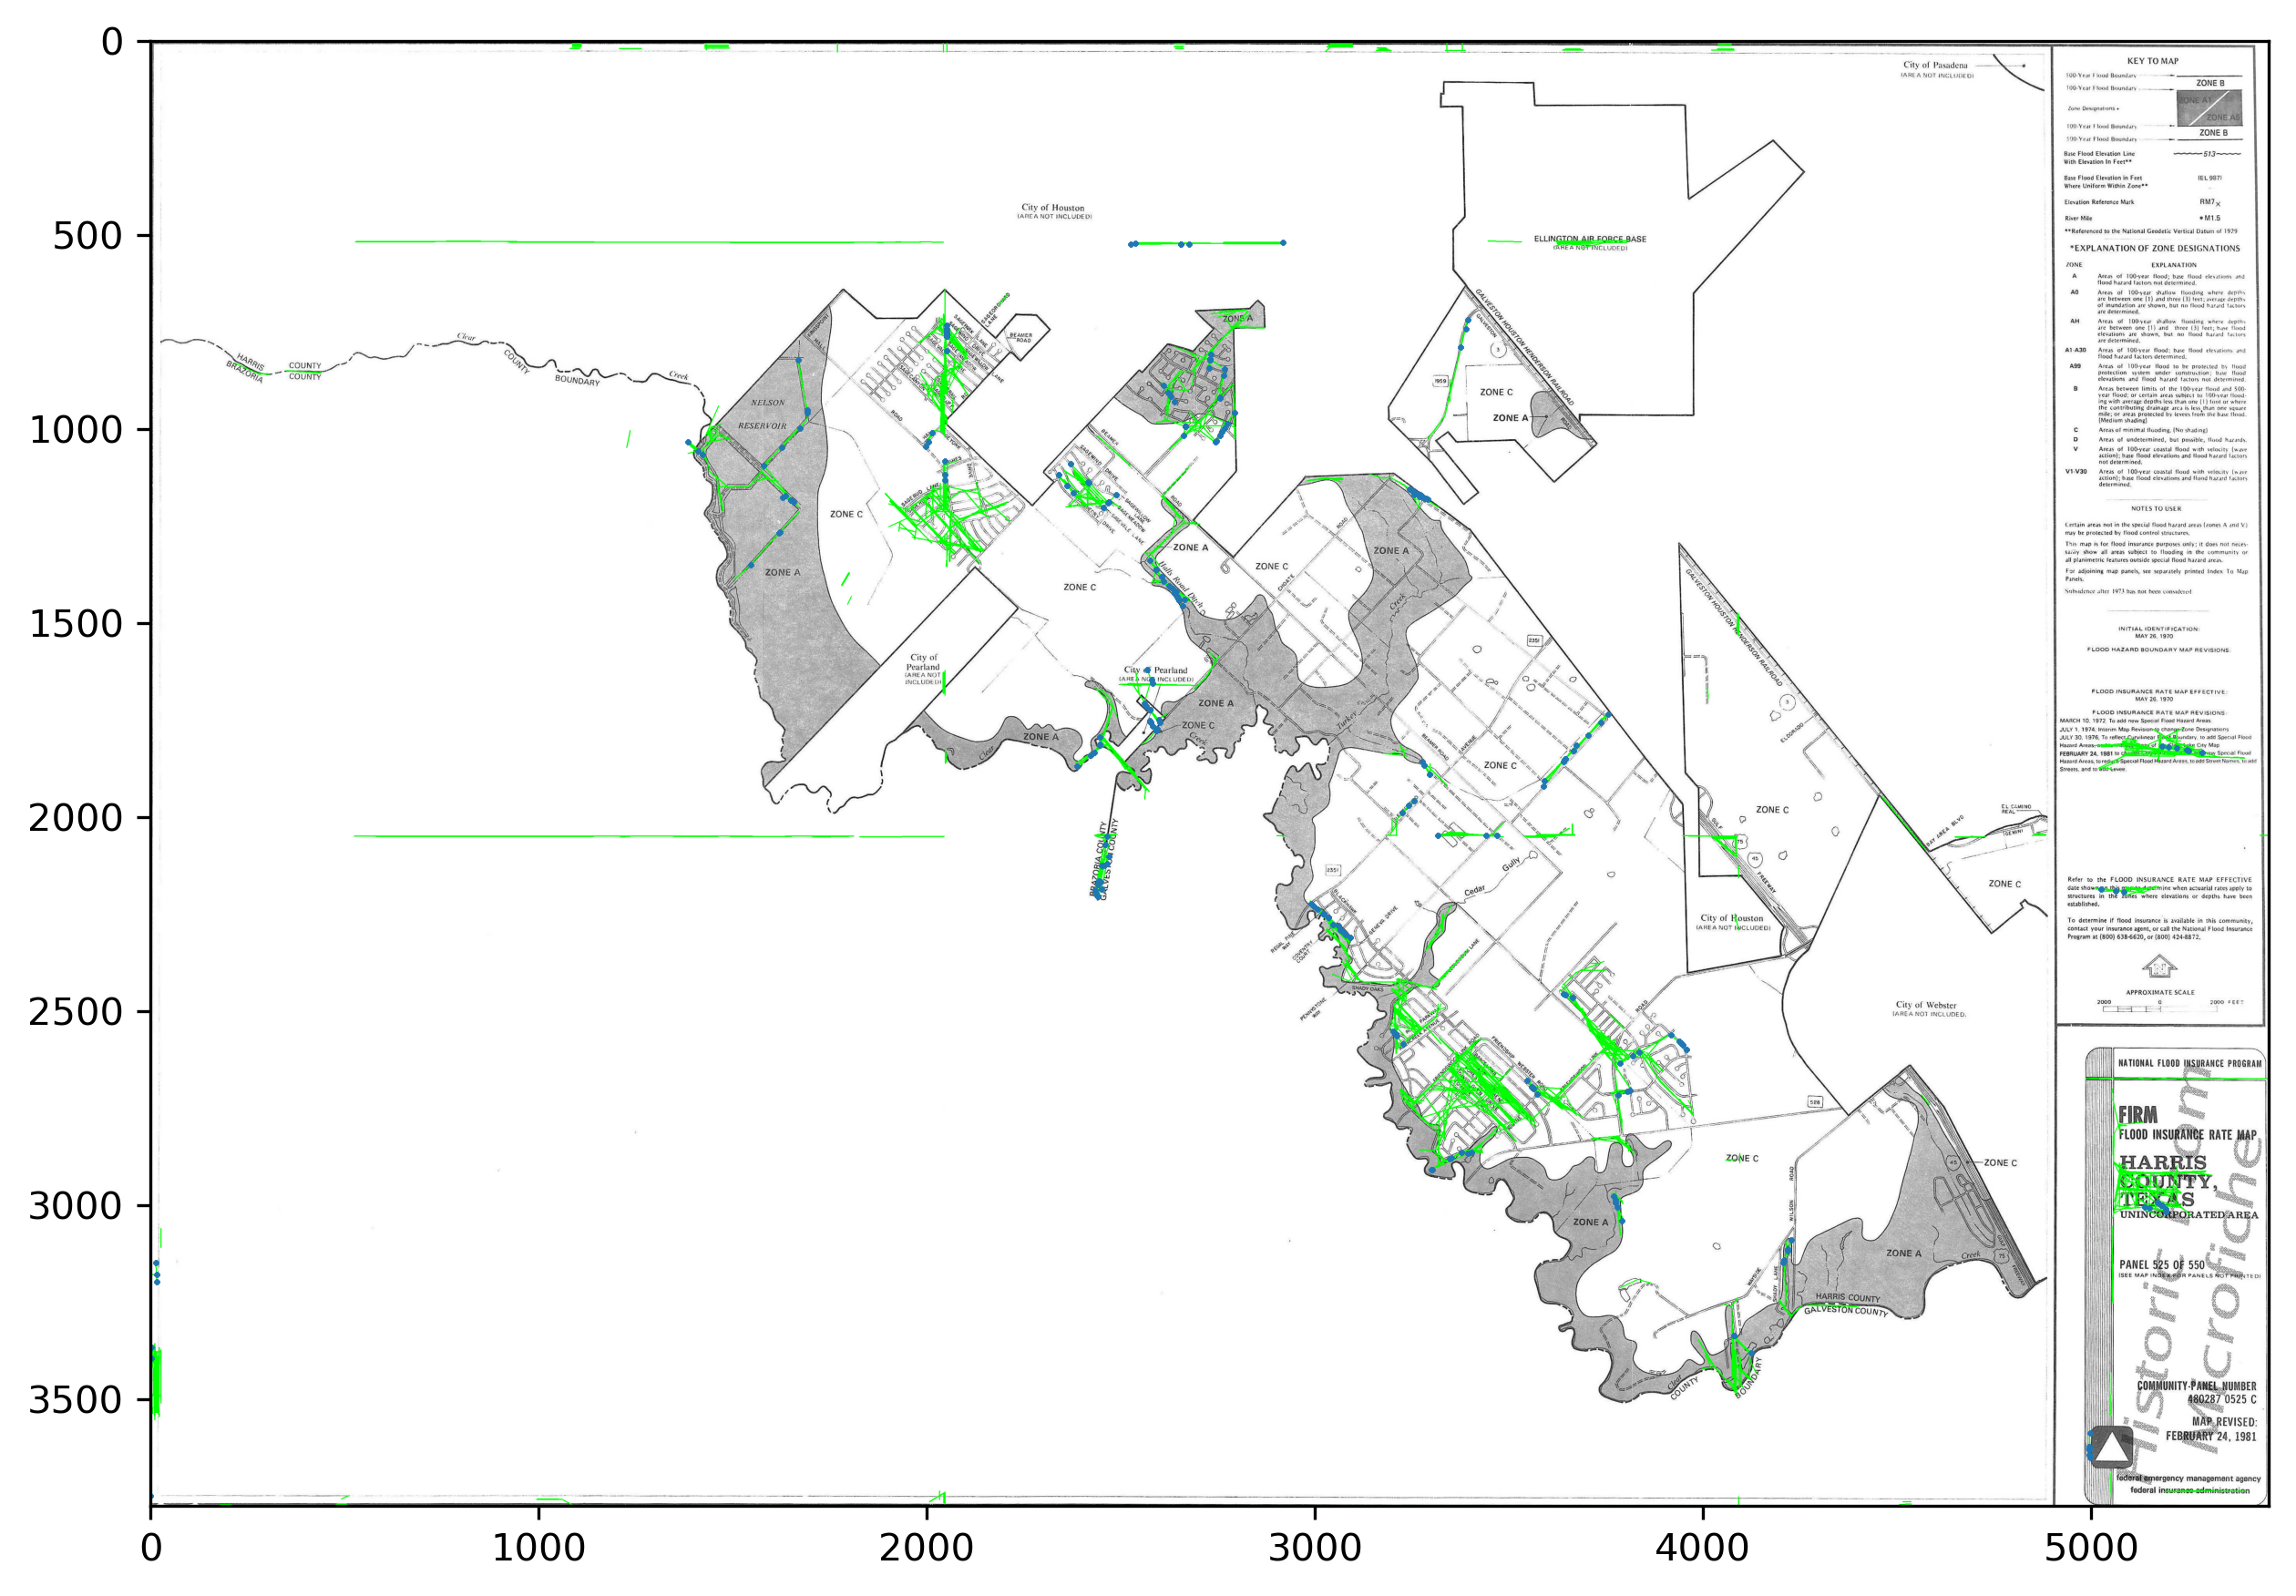

In [17]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ax.imshow(image_rgb)
ax.scatter(inters.geometry.x.tolist(), inters.geometry.y.tolist(), marker='x', s=0.5)
fig.savefig("test.png")

[[   0    0]
 [   0    1]
 [   0    2]
 ...
 [5455 2490]
 [5455 2837]
 [5455 2937]]


[3888.0,
 3895.0,
 3888.2364864864862,
 4759.0,
 4827.0,
 4814.636363636367,
 1223.0,
 1250.0,
 1231.6504854368934,
 2020.2500000000014,
 1970.0,
 2018.6741010918677,
 2030.0,
 2014.7999999999972,
 2963.0,
 2978.0,
 2974.666666666667,
 3834.0,
 3941.0,
 3938.0277777777783,
 3294.0,
 3299.0,
 3297.015873015873,
 1953.0,
 1924.0,
 1930.4444444444448,
 3374.0,
 3394.4680357887905,
 3406.0,
 3375.8113207547167,
 3405.1351351351354,
 1530.0,
 1505.0,
 1526.694214876036,
 4692.0,
 4712.0,
 4701.88679245283,
 2459.0,
 2465.230769230768,
 2480.0,
 2417.0,
 2462.0,
 2443.999999999998,
 2423.42857142857,
 1153.0,
 1190.0,
 1186.105263157894,
 2777.0,
 2886.0,
 2863.2638036809803,
 1045.0,
 1152.0,
 1087.125984251969,
 4678.0,
 4724.0,
 4722.647058823532,
 3099.1311475409843,
 3092.0,
 3150.0,
 1495.0,
 1501.0,
 1496.094117647059,
 1302.0,
 1386.0,
 1360.966887417219,
 3178.0,
 3233.0,
 3230.3713235294113,
 2936.0,
 3028.0,
 2948.5170068027205,
 1389.0,
 1446.93893129771,
 1455.0,
 1908.0,
 1892.

In [119]:
intersections

0                LINESTRING (0.000 0.000, 2047.000 0.000)
1         LINESTRING (5455.000 2333.000, 5455.000 53.000)
2             LINESTRING (4021.000 0.000, 4718.000 0.000)
3       LINESTRING (2974.000 2393.000, 3043.000 2393.000)
4             LINESTRING (4754.000 0.000, 5328.000 0.000)
                              ...                        
7467    MULTIPOINT (3606.000 2085.000, 3615.000 2100.0...
7468    MULTILINESTRING ((4362.000 1681.000, 4366.053 ...
7469        LINESTRING (4761.000 70.000, 4779.000 86.000)
7470    LINESTRING (2810.000 1118.000, 2820.000 1123.000)
7471      LINESTRING (4380.000 208.000, 4381.000 198.000)
Name: geometry, Length: 7472, dtype: geometry

In [97]:
def toTF(a):
    a[a > 0] = 1
    a[a <= 0] = 0
    return a

def filterIntersections(inters, lines, fn):

    # APPROACH WITH IMAGE FILTERING. DOESNT WORK
    image_filter = np.asarray(cv2.imread(fn) * 0)
    inter_filter = np.asarray(cv2.imread(fn) * 0)[:, :, 0]

    # Plot the lines
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_filter, (x1, y1), (x2, y2), (255, 255, 255), 2)

    image_filter = image_filter[:, :, 0]
    # CREATE IMAGE MASK
    # Extract x, y coordinates of intersection points
    x_coords, y_coords = zip(*inters)
    # Set the intersection points to white (255) in the mask
    inter_filter[y_coords, x_coords] = 255
    print(inter_filter.shape)
    print(image_filter.shape)


    return toTF(image_filter) * toTF(inter_filter)

test = filterIntersections(inters, lines, fn)

(3767, 5456)
(3767, 5456)


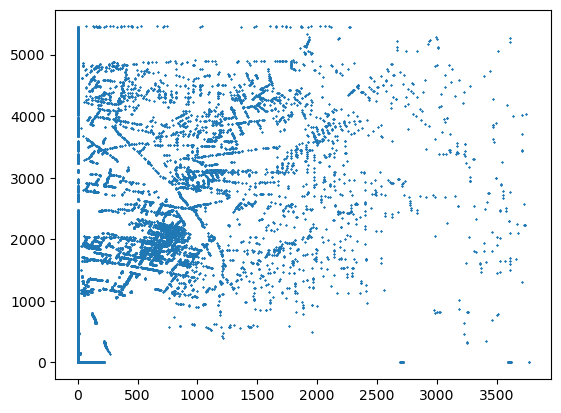

In [101]:
y, x = np.where(test)

plt.scatter(y, x, s=0.5, marker='x')